In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')

# Propositional Classifiers:

In this notebook I try to design classifiers that act on the set of all blocks and output a tiebreaker binary label having access only to the features given by Henry in the focal students dataset. Those features are:

1. Total number of students per block (used for normalization purposes)
2. Number of FRL students per block
3. Number of AALPI students per block
4. Number of FRL and AALPI students per block (i.e. intersection of those)

The classifiers will evaluate a logical proposition with those features. For example, an "AND" classifier can be of the form:

$$ \text{AALPI} \geq 0.5 \quad \text{and} \quad \text{FRL} \geq 0.7 $$

This classifier will give an equity tiebreaker to a block if and only if that block has over 50% of its students in the AALPI racial group and over 70% of its students receiving FRL.

Currently we do not have a systematic way to think of these types of propositions. But we can evaluate their performance based on false positive and false negative rates. In the case of two parameters (i.e. two numeric comparisons), it is possible to visualize the precision-recall curve.

## 1. Preparing the Data

In [2]:
from src.d01_data.block_data_api import BlockDataApi
from src.d02_intermediate.block_data_cleaning import frl_raw_to_pc

To use the propositional classifiers, we need to format the FRL data. The block_data_cleaning script has the function to turn raw frl data into the input we need:

In [3]:
block_data_api = BlockDataApi()
frl_df = block_data_api.get_data(frl=True, user="gabriel")
frl_df_pc = frl_raw_to_pc(frl_df)

In [4]:
frl_df_pc

,Geoid10,COUNT,FRL,AALPI,BOTH,AALPI (%),FRL (%),BOTH (%)
0,060750428002003,1.00,1.00,1.00,1.00,1.000000,1.000000,1.000000
1,060750230013005,1.00,1.00,1.00,1.00,1.000000,1.000000,1.000000
2,060750229032009,1.00,1.00,1.00,1.00,1.000000,1.000000,1.000000
3,060750228011005,1.00,1.00,1.00,1.00,1.000000,1.000000,1.000000
4,060750132002005,1.00,1.00,1.00,1.00,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
4589,060750610001004,168.75,91.75,75.25,48.00,0.445926,0.543704,0.445926
4590,060750234002014,176.75,153.25,147.00,127.75,0.831683,0.867044,0.831683
4591,060750231032017,187.25,136.25,149.00,107.00,0.795728,0.727637,0.795728
4592,060750605022000,197.00,174.50,140.50,121.25,0.713198,0.885787,0.713198


The above dataframe contains all the possible columns we could use in our classification. Most of the times we will deal with relative comparisons (is over half of a block focal?), but the absolute counts are important to give an idea of false positives and false negatives. Besides, we might want to mix absolute and relative counts: blocks with a great number of students may require that we look at absolute counts, otherwise we could be neglecting too many focal students.

## 2. Class Syntax

We load the propositional classifier classes from the modelling library:

In [5]:
from src.d04_modeling import propositional_classifier as pc

In its most general form, the propositional classifier class takes as an input a list of features that we will be using for evaluation, a list of logical operators ("and" or "or"), and a list of comparisors ($\geq$, $\leq$, =). By default, this comparisor lists is a sequence of $\geq$ since that is the most likely case. The lists must be in the order of the statement we want to construct, and notice that there will always be one less operator than features. For example:

In [28]:
pc1 = pc.Propositional_Classifier(["AALPI (%)", "FRL (%)", "BOTH"], ["and", "or"])
pc1.statement

'AALPI (%) >=  {0:.2f} and FRL (%) >=  {1:.2f} or BOTH >=  {2:.2f}'

Note that the parameters are not required upon initialization. Rather, the statement is constructed so we can input parameters when doing the predictions. This way we can vary parameters and build precision-recall cruves.

Simple and/or classifiers have their own child class, in which we only need to pass the features (and comparisors if not default):

In [13]:
pc2 = pc.AND_Classifier(["AALPI (%)", "FRL (%)"])
pc2.statement

'AALPI (%) >=  {0:.2f} and FRL (%) >=  {1:.2f}'

In [14]:
pc3 = pc.OR_Classifier(["AALPI (%)", "FRL (%)"])
pc3.statement

'AALPI (%) >=  {0:.2f} or FRL (%) >=  {1:.2f}'

Some logical statements need parentheses. Some do not, but we would rather read them with parentheses as that is easier (for example, the first example pc1 is hard to interpret without parenthesis---computer evaluates it in order). Simply pass a tuple of features as an element. Note that operands must still be of the correct length!

In [15]:
pc4 = pc.Propositional_Classifier(["AALPI (%)", ("FRL (%)", "BOTH (%)"), "BOTH"], ["or", "and", "or"])
pc4.statement

'AALPI (%) >=  {0:.2f} or  (FRL (%) >=  {1:.2f} and BOTH (%) >=  {2:.2f} ) or BOTH >=  {3:.2f}'

Once we have initialized our statement we can use the predict method with the appropriate data and parameters to do a round of prediction.

In [33]:
params1 = [0.5, 0.8, 10] #parameters must match the features passed, in the order.
pred1 = pc1.predict(frl_df_pc, params1)
pred1

array([ True,  True,  True, ...,  True,  True,  True])

This binary array tells us which blocks receive the tiebreaker. We can visualize the result in the San Francisco map:

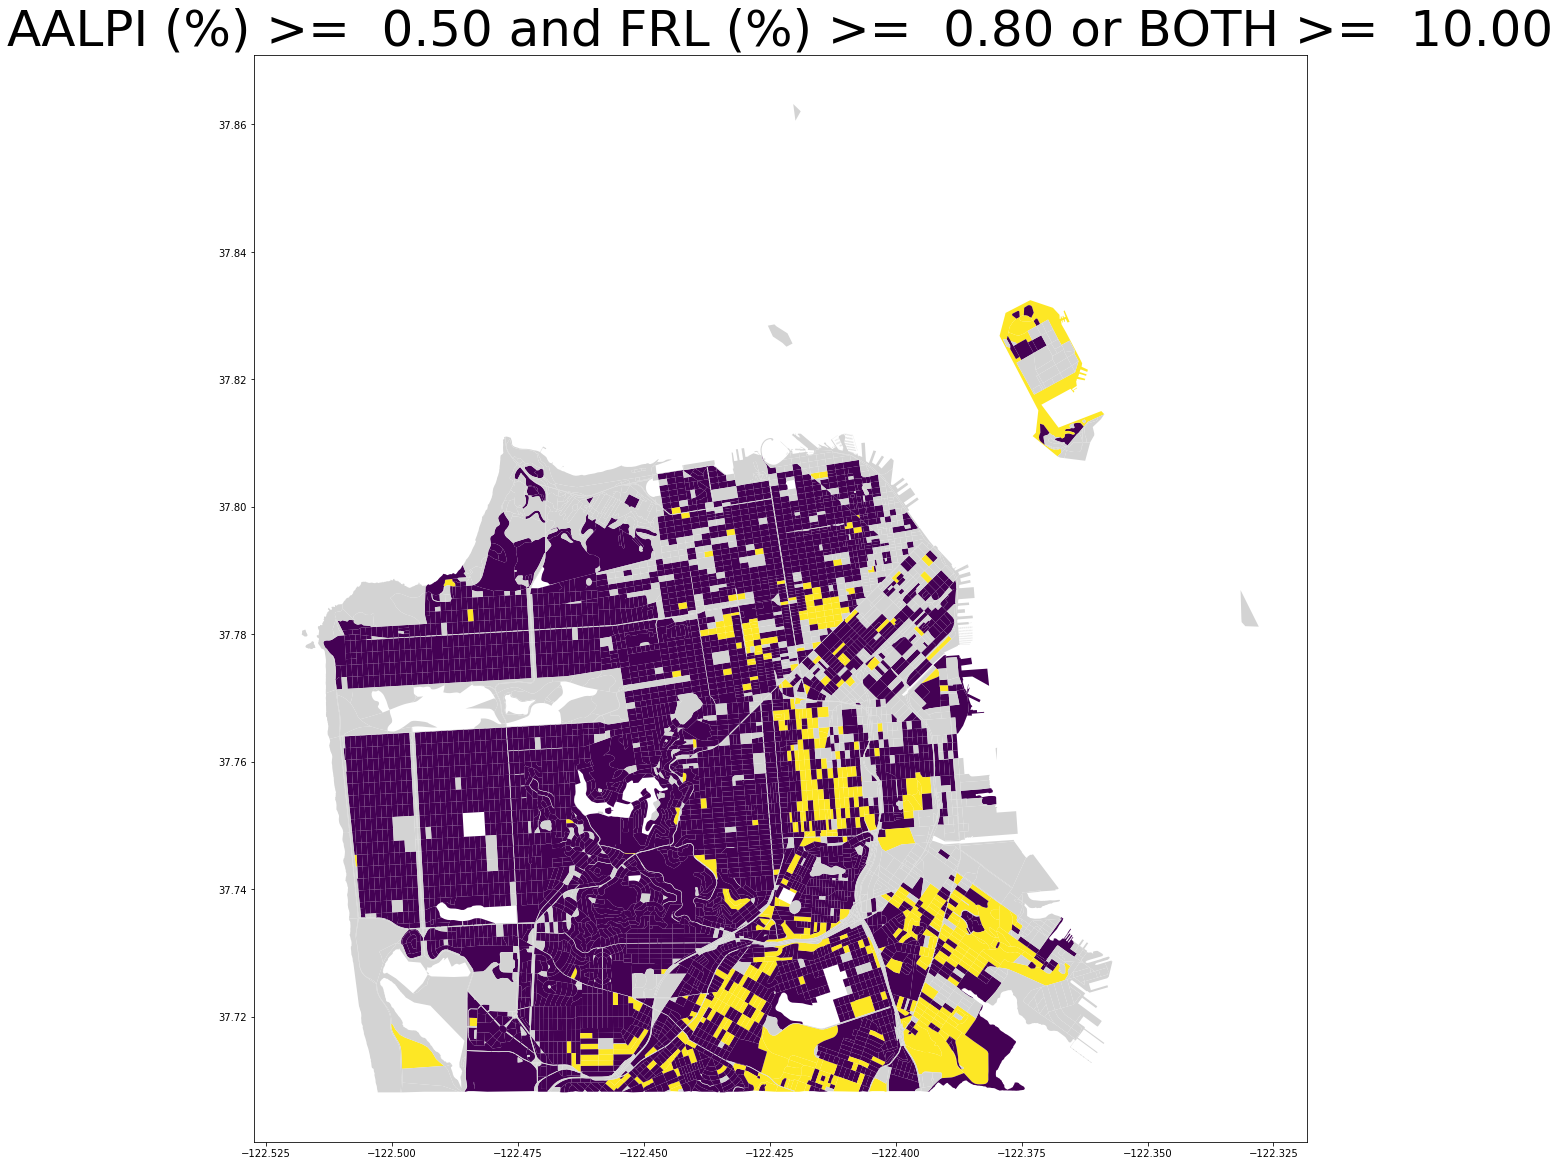

In [34]:
pc1.display_map(frl_df_pc, pred1)

The confusion matrix of this classifier are saved on a dictionary whose key is the parameter tuples for which a predicition has been made:

In [35]:
pc1.confusion_dict

{(0.5,
  0.6,
  10): array([[17067.75      , 18577.25      ],
        [ 2131.41666667, 17780.16666667]]),
 (0.5,
  0.8,
  10): array([[15435.08333333, 20209.91666667],
        [ 1899.33333333, 18012.25      ]])}

Using that we can retrive any rate for evaluating purposes. We can get the FPR and FNR for example:

In [36]:
fpr, fnr = pc1.get_rates(params1, which=["fpr", "fnr"])
print("False positive rate is {0:.2f} %".format(100*fpr))
print("False negative rate is {0:.2f} %".format(100*fnr))

False positive rate is 9.54 %
False negative rate is 56.70 %


To interpret the above map: we wanted the FRL percentage to be very high (above 80%) and the AALPI percentage to be at least half; OR if there were at least 10 students in a block in the intersection count, the block would be given a tiebreaker regardless of its relative composition. We can see in the map that due to the AALPI criterion having to be satisfied most blocks that received a tiebreaker are in the SouthEast (where racial minorities are more concentrated). This criterion is very restrictive: the false negative rate is super high, meaning that we "missed" a lot of focal students. However, very few non-focal students received an advantage (less that 10%).

## 3. Exploring the parameter space

Ideally we would like to explore several points for the trade-off between FP and FN.

In one-dimensional parameter spaces (i.e. only one feature is pased to the classifier, so that we have only one parameter) this can be done via analysis of the ROC curve (similar to precision-recall):

In [ ]:
pc5 = pc.Propositional_Classifier(["BOTH (%)"], [])

In [ ]:
pc5.statement

In [ ]:
pc5.display_ROCcurve(frl_df_pc, params_range=(0,1), n_params=100)

In two-dimensional parameter spaces (i.e. only two features are pased to the classifier, so that we have only two parameters) this can be done via analysis of two matrices of false positives and false negatives. This would be equivalent to a ROC surface.

In [ ]:
pc2.statement

In [ ]:
pc2.display_heat(frl_df_pc, params_range=(0,1), n_params=10)

In [ ]:
pc3.statement

In [ ]:
pc3.display_heat(frl_df_pc, params_range=(0,1), n_params=10)

An alternative is to fix all but one parameters of the propositions so that we can build a ROC curve. Using:

$$ \left(\text{AALPI } \geq 50\%  \quad \text{and} \quad \text{FRL } \geq 60\%\right)\quad\text{or}\quad \text{BOTH } (\%)\geq \gamma$$

In [37]:
pc6 = pc.Propositional_Classifier(["AALPI (%)", "FRL (%)", "BOTH (%)"], ["and", "or"])

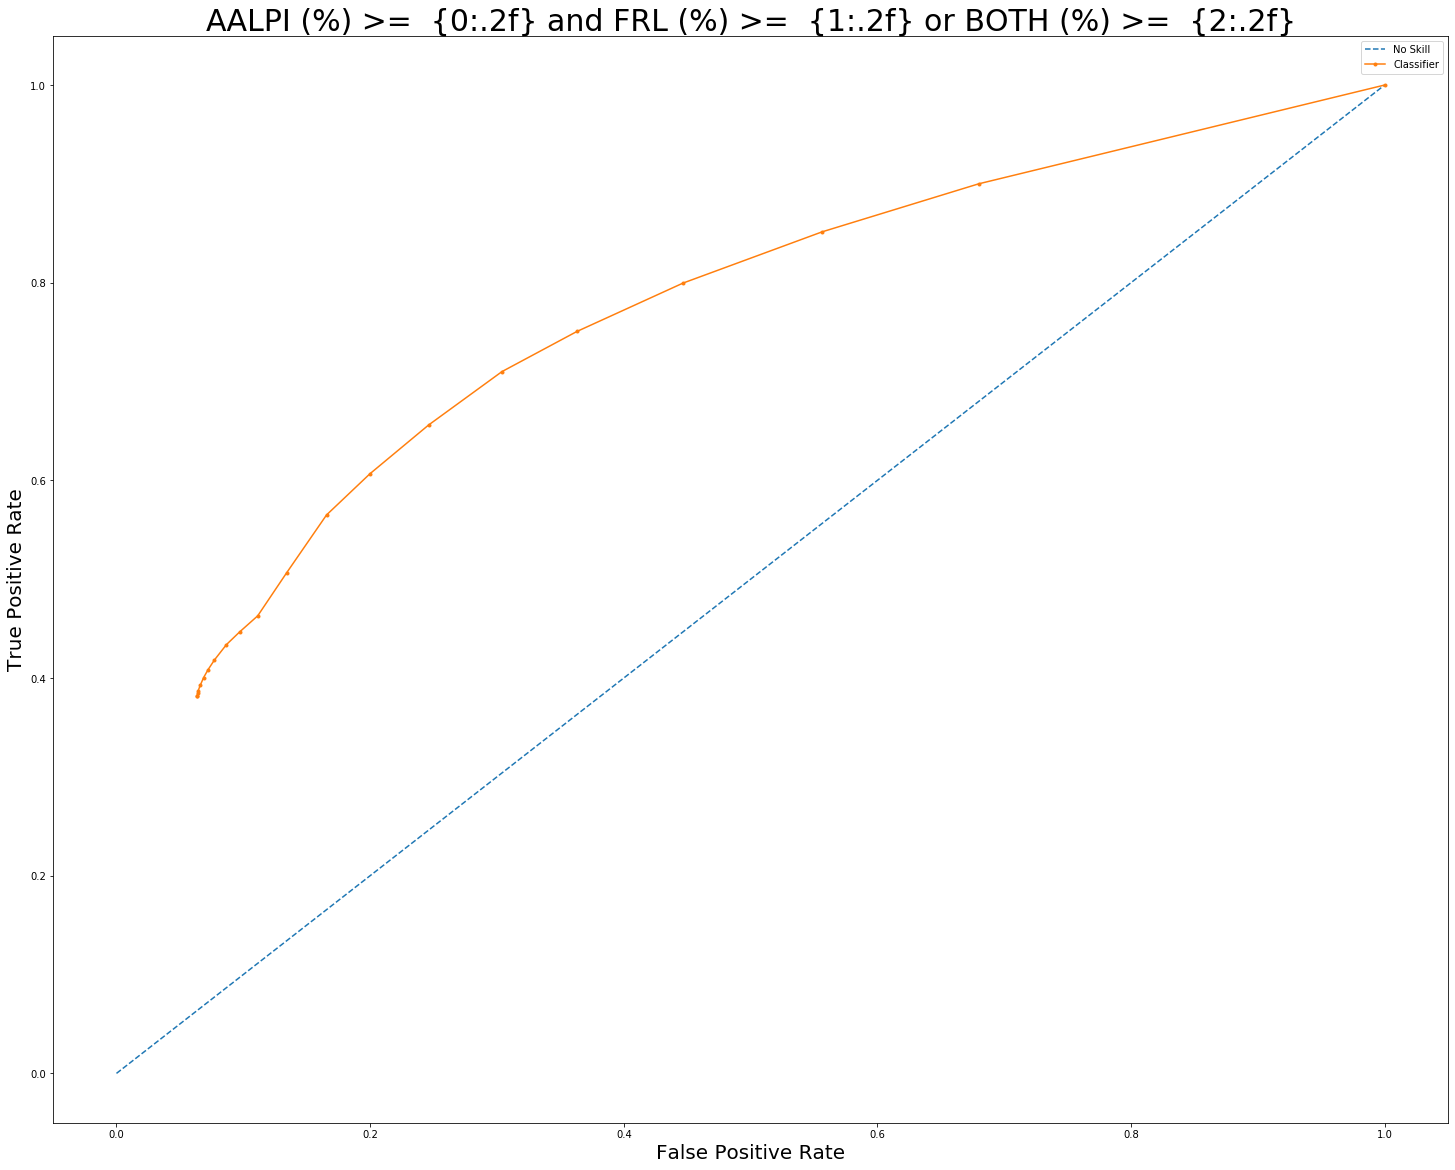

In [41]:
fpr_arr = []
tpr_arr = []
    
for gamma in [i/20 for i in range(21)]:
    params = [0.5, 0.6, gamma]
    pred = pc6.predict(frl_df_pc, params)
    data_fpr, data_tpr = pc6.get_rates(params, ["fpr", "tpr"])
    fpr_arr.append(data_fpr)
    tpr_arr.append(data_tpr)

fpr_arr = np.array(fpr_arr)
tpr_arr = np.array(tpr_arr)

fig, ax = plt.subplots(figsize=(25,20))        
ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
ax.plot(fpr_arr, tpr_arr, marker='.', label="Classifier")
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title(pc6.statement, fontsize=30)
ax.legend()

True